# Initialization

In [1]:
import os
import re
import numpy as np
import random

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline

### set experiment dates

In [2]:
year = 2005 

### set directories

In [3]:
dir_root = os.path.join('..')
dir_data_processing = os.path.join(dir_root, 'data_processing')
dir_reports_ready =  os.path.join(dir_data_processing, 'reports_ready')
dir_plots = os.path.join(dir_root, 'plots')

### set flags

In [4]:
flag_debug = False

# Read data reports from files

In [5]:
def read_report(dir_name, file_name):
    file_path = os.path.join(dir_name, file_name)
    result = []
    with open(file_path, 'r') as f_r:
        for text_line in f_r:
            result = result + text_line.strip().split(' ')
    return result        

In [6]:
reports_list = []

regExp = re.compile('[A-Z\d]+\_[A-Z\d]+\-' + str(year) + '\_[\d]+\.txt$')
reports_of_year = [f for f in os.listdir(dir_reports_ready) if re.search(regExp, f)]
reports_of_year.sort()
# for every reports of the year
for report_name in reports_of_year:
    reports_list.append(read_report(dir_reports_ready, report_name))

print('Done on %s, number of documents: %s' % (year, len(reports_of_year)))

Done on 2005, number of documents: 233


# Corpus construction

In [7]:
import gensim
import gensim.corpora as corpora

## Create Dictionary

In [8]:
id2word = corpora.Dictionary(reports_list)

## Create Corpus

Shuffle reporst

In [9]:
random.Random(99).shuffle(reports_list)

Split between training and test set

In [10]:
testing_size = len(reports_list) // 10
training_size = len(reports_list) - testing_size

In [11]:
print('Total %s reprorts' % len(reports_list))
print('Training %s reprorts' % training_size)
print('Testing %s reprorts' % testing_size)

Total 233 reprorts
Training 210 reprorts
Testing 23 reprorts


In [12]:
training_corpus = [id2word.doc2bow(text) for text in reports_list[:training_size]]
test_corpus = [id2word.doc2bow(text) for text in reports_list[testing_size:]]

corpus = [id2word.doc2bow(text) for text in reports_list]

In [13]:
print('Number of unique tokens: %s' %len(id2word))

Number of unique tokens: 13741


view the first document as BOW

In [14]:
if flag_debug:
    print(corpus[:1])

# Find optimal topic number

In [15]:
from gensim.models import CoherenceModel

In [32]:
def compute_coherence_values(dictionary, training_corpus, test_corpus, texts, limit, start=2, step=3, passes=10, random_state=100):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    perplexity_values = []
    model_list = []
    bound_values = []
    i = 0
    for num_topics in range(start, limit + 1, step):
        model = gensim.models.ldamodel.LdaModel(corpus=training_corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics, 
                                           random_state=random_state,
                                           update_every=5,
                                           chunksize=100,
                                           passes=passes,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v_score = coherencemodel.get_coherence()
        coherence_values.append(c_v_score)
        
        bound = model.log_perplexity(test_corpus)
        bound_values.append(bound)
        
        perplexity = np.exp2(-bound)
        perplexity_values.append(perplexity)
        
        print('Done on indx: %s T: %s, c_v score: %s, bound: %s, perplexity: %s' % (i, num_topics, c_v_score, bound, perplexity))
        i += 1
    return model_list, coherence_values, perplexity_values, bound_values


In [35]:
min_T = 5
max_T = 60
step_T = 1
passes_T = 51
random_state = 193748

In [36]:
model_list, coherence_values, perplexity_values, bound_values = compute_coherence_values(
    dictionary=id2word, 
    training_corpus=training_corpus, 
    test_corpus=test_corpus,
    texts=reports_list, 
    start=min_T, 
    limit=max_T, 
    step=step_T,
    passes=passes_T,
    random_state=random_state)

Done on indx: 0 T: 5, c_v score: 0.37172281404369734, bound: -8.048648992197768, perplexity: 264.7797520995808
Done on indx: 1 T: 6, c_v score: 0.378066225249233, bound: -8.029982944683729, perplexity: 261.3760142162105
Done on indx: 2 T: 7, c_v score: 0.38251400958616477, bound: -8.00289238608337, perplexity: 256.5137562400725
Done on indx: 3 T: 8, c_v score: 0.3833927443321606, bound: -7.970833453737309, perplexity: 250.8764872050569
Done on indx: 4 T: 9, c_v score: 0.41141406320685914, bound: -7.952984400090065, perplexity: 247.79175948969228
Done on indx: 5 T: 10, c_v score: 0.49521290185696853, bound: -7.914048441773803, perplexity: 241.19370461196416
Done on indx: 6 T: 11, c_v score: 0.4218229213640393, bound: -7.9172559278773385, perplexity: 241.73053745381674
Done on indx: 7 T: 12, c_v score: 0.45001839853605685, bound: -7.899621038019221, perplexity: 238.79371211499839
Done on indx: 8 T: 13, c_v score: 0.44335506078035947, bound: -7.90350558383032, perplexity: 239.437545376021

In [37]:
import math
for i in range(len(coherence_values)):
    if math.isnan(coherence_values[i]):
        coherence_values[i] = 0

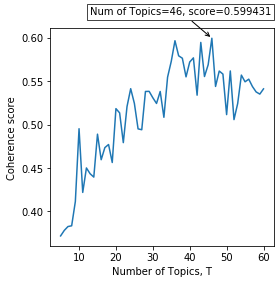

In [38]:
plt.figure(figsize=(4,4))

        
y = np.array(coherence_values)
x = np.array(range(min_T, max_T + 1, step_T))

plt.plot(x, y)    
    
    
xmax = x[np.argmax(y)]
ymax = y.max()
text = 'Num of Topics=%s, score=%f' % (xmax, ymax)

bbox_props = dict(boxstyle='square,pad=0.3', fc='w', ec='k', lw=0.72)
arrowprops=dict(arrowstyle='->')
kw = dict(xycoords='data',textcoords='axes fraction',
          arrowprops=arrowprops, bbox=bbox_props, ha='right', va='top')
plt.annotate(text, xy=(xmax, ymax), xytext=(0.99,1.1), **kw)


plt.xlabel('Number of Topics, T')
plt.ylabel('Coherence score')

#pp = PdfPages(os.path.join(dir_topics, 'cohearence_score.pdf'))

#plt.savefig(pp, format='pdf', bbox_inches='tight')
plt.show()

#pp.close() 
plt.close()

<Figure size 360x360 with 0 Axes>

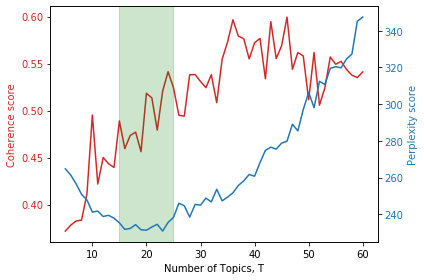

In [39]:
plt.figure(figsize=(5,5))

      
data1 = np.array(coherence_values)
data2 = np.array(perplexity_values)
x = np.array(range(min_T, min_T + len(data1), step_T))

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Number of Topics, T')
ax1.set_ylabel('Coherence score', color=color)
ax1.plot(x, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

xmax = x[np.argmax(data1)]
ymax = data1.max()
text = 'Num of Topics=%s, score=%f' % (xmax, ymax)

#bbox_props = dict(boxstyle='square,pad=0.3', fc='w', ec='k', lw=0.72)
#arrowprops = dict(arrowstyle='->')
#kw = dict(xycoords='data',textcoords='axes fraction',
          #arrowprops=arrowprops, bbox=bbox_props, ha='right', va='top')
#ax1.annotate(text, xy=(xmax, ymax), xytext=(0.99,1.1), **kw)

# instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Perplexity score', color=color)
ax2.plot(x, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.axvspan(15, 25, color='green', alpha=0.2)

fig.tight_layout() # otherwise the right y-label is slightly clipped

pp = PdfPages(os.path.join(dir_plots, 'cohearence_score.pdf'))

plt.savefig(pp, format='pdf', bbox_inches='tight')
plt.show()

pp.close() 

In [40]:
all_columns = len(coherence_values)
columns = 10
rows = math.ceil(all_columns / columns)

In [41]:
print('\\begin{tabular}{l|%s}' % '|'.join(['c'] * columns))

for r in range(rows):
    start = r * columns
    end = (r + 1) * columns
    
    print('\\hline')
    print('\\textbf{T} & %s \\\\ ' % ' & '.join(['%s' % (x + 5) for x in range(start, end)]))
    print('\\hline')
    print('\\textbf{Coherence score}  & %s \\\\ ' % ' & '.join(['%.4f' % x for x in coherence_values[start:end]]))
    print('\\textbf{Perplexity score} & %s \\\\ ' % ' & '.join(['%.4f' % x for x in perplexity_values[start:end]]))


\begin{tabular}{l|c|c|c|c|c|c|c|c|c|c}
\hline
\textbf{T} & 5 & 6 & 7 & 8 & 9 & 10 & 11 & 12 & 13 & 14 \\ 
\hline
\textbf{Coherence score}  & 0.3717 & 0.3781 & 0.3825 & 0.3834 & 0.4114 & 0.4952 & 0.4218 & 0.4500 & 0.4434 & 0.4395 \\ 
\textbf{Perplexity score} & 264.7798 & 261.3760 & 256.5138 & 250.8765 & 247.7918 & 241.1937 & 241.7305 & 238.7937 & 239.4375 & 237.9034 \\ 
\hline
\textbf{T} & 15 & 16 & 17 & 18 & 19 & 20 & 21 & 22 & 23 & 24 \\ 
\hline
\textbf{Coherence score}  & 0.4889 & 0.4595 & 0.4735 & 0.4770 & 0.4563 & 0.5183 & 0.5135 & 0.4792 & 0.5207 & 0.5413 \\ 
\textbf{Perplexity score} & 235.3158 & 231.7854 & 232.2610 & 234.3487 & 231.5449 & 231.3166 & 233.0604 & 234.5507 & 230.8370 & 235.5678 \\ 
\hline
\textbf{T} & 25 & 26 & 27 & 28 & 29 & 30 & 31 & 32 & 33 & 34 \\ 
\hline
\textbf{Coherence score}  & 0.5244 & 0.4950 & 0.4940 & 0.5381 & 0.5383 & 0.5309 & 0.5243 & 0.5381 & 0.5084 & 0.5546 \\ 
\textbf{Perplexity score} & 238.2924 & 246.0113 & 244.6446 & 238.4626 & 245.3519 & 244.98

In [42]:
take_first_t_index = 20
coherence_values_in_use = coherence_values[:take_first_t_index]
perplexity_values_in_use = perplexity_values[:take_first_t_index]

<Figure size 360x360 with 0 Axes>

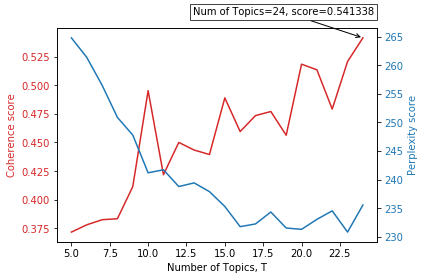

In [43]:
plt.figure(figsize=(5,5))

      
data1 = np.array(coherence_values_in_use)
data2 = np.array(perplexity_values_in_use)
x = np.array(range(min_T, min_T + len(data1), step_T))

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Number of Topics, T')
ax1.set_ylabel('Coherence score', color=color)
ax1.plot(x, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

xmax = x[np.argmax(data1)]
ymax = data1.max()
text = 'Num of Topics=%s, score=%f' % (xmax, ymax)

bbox_props = dict(boxstyle='square,pad=0.3', fc='w', ec='k', lw=0.72)
arrowprops = dict(arrowstyle='->')
kw = dict(xycoords='data',textcoords='axes fraction',
          arrowprops=arrowprops, bbox=bbox_props, ha='right', va='top')
ax1.annotate(text, xy=(xmax, ymax), xytext=(0.99,1.1), **kw)

# instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Perplexity score', color=color)
ax2.plot(x, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() # otherwise the right y-label is slightly clipped
pp = PdfPages(os.path.join(dir_plots, 'cohearence_score_zoom.pdf'))

plt.savefig(pp, format='pdf', bbox_inches='tight')
plt.show()

pp.close() 

In [44]:
best_model_index = np.argmax(np.array(data1))
ts = np.array(range(min_T, min_T + len(data1) + 1, step_T))


best_topics_number = ts[best_model_index]
best_model = model_list[best_model_index]

In [45]:
print('Best T: %s' % best_topics_number)

Best T: 24


## Combined plot

ValueError: x and y must have same first dimension, but have shapes (20,) and (56,)

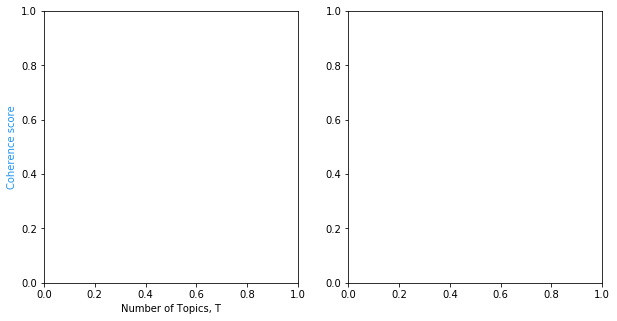

In [46]:
zoom_min_t = 15
zoom_max_t = 25

x_left = np.array(range(min_T, min_T + len(data1), step_T))
x_right = np.array(range(zoom_min_t, zoom_max_t + 1, step_T))

color_corherence = '#1f94f9'#hsl(208, 95%, 55%) # #1f94f9
color_preplexity = '#f9591f' #hsl(16, 95%, 55%) # #f9591f
fig, axs = plt.subplots(1, 2, figsize=(10,5))

# Left cohereance
ax_left_main = axs[0]
data_left_coherence = np.array(coherence_values)
ax_left_main.set_xlabel('Number of Topics, T')
ax_left_main.set_ylabel('Coherence score', color=color_corherence)
ax_left_main.plot(x_left, data_left_coherence, color=color_corherence)
ax_left_main.tick_params(axis='y', labelcolor=color_corherence)

# Left Preplexity
ax_left_twinx = ax_left_main.twinx()  
data_left_preplexity = np.array(perplexity_values)
ax_left_twinx.set_ylabel('Perplexity score', color=color_preplexity)
ax_left_twinx.plot(x_left, data_left_preplexity, color=color_preplexity)
ax_left_twinx.tick_params(axis='y', labelcolor=color_preplexity)
plt.axvspan(zoom_min_t, zoom_max_t, color='green', alpha=0.2)

## Add max point
xmax = x_left[np.argmax(data_left_preplexity)]
ymax = data_left_preplexity.max()
text = 'Max Perplexity Score=%f, Num of Topics=%s' % (ymax, xmax)

bbox_props = dict(boxstyle='square,pad=0.3', fc='w', ec='k', lw=0.72)
arrowprops = dict(arrowstyle='->')
kw = dict(xycoords='data',textcoords='axes fraction',
          arrowprops=arrowprops, bbox=bbox_props, ha='right', va='top')
ax_left_twinx.annotate(text, xy=(xmax, ymax), xytext=(0.99,1.1), **kw)



# Rigth cohereance
ax_right_main = axs[1]
data_right_coherence = np.array(coherence_values[zoom_min_t - min_T: (zoom_max_t-min_T) + 1])
ax_right_main.set_xlabel('Number of Topics, T')
ax_right_main.set_ylabel('Coherence score', color=color_corherence)
ax_right_main.plot(x_right, data_right_coherence, color=color_corherence, label='Coherence $C_v$')
ax_right_main.tick_params(axis='y', labelcolor=color_corherence)

## Add max point
xmax = x_right[np.argmax(data_right_coherence)]
ymax = data_right_coherence.max()
text = 'Max Coherence Score=%f, Num of Topics=%s' % (ymax, xmax)

bbox_props = dict(boxstyle='square,pad=0.3', fc='w', ec='k', lw=0.72)
arrowprops = dict(arrowstyle='->')
kw = dict(xycoords='data',textcoords='axes fraction',
          arrowprops=arrowprops, bbox=bbox_props, ha='right', va='top')
ax_right_main.annotate(text, xy=(xmax, ymax), xytext=(0.99,1.1), **kw)

# Right Preplexity
ax_right_twinx = ax_right_main.twinx()  
data_right_preplexity = np.array(perplexity_values[zoom_min_t - min_T: (zoom_max_t-min_T) + 1])
ax_right_twinx.set_ylabel('Perplexity score', color=color_preplexity)
ax_right_twinx.plot(x_right, data_right_preplexity, color=color_preplexity, label='Perplexity')
ax_right_twinx.tick_params(axis='y', labelcolor=color_preplexity)


fig.tight_layout() # otherwise the right y-label is slightly clipped

#handles, labels = ax_right_twinx.get_legend_handles_labels()
#lgd = ax_right_twinx.legend(handles, labels, bbox_to_anchor=(1, 1), loc="lower center", ncol=3, handleheight=2.4, labelspacing=0.05)
all_labels = [ax.get_legend_handles_labels() for ax in [ax_right_main, ax_right_twinx]]
lines, labels = [sum(x, []) for x in zip(*all_labels)]
fig.legend(lines, labels, bbox_to_anchor=(1, 0.5), loc='center left')
# finally we invoke the legend (that you probably would like to customize...)

pp = PdfPages(os.path.join(dir_plots, 'search_T_plot.pdf'))
plt.savefig(pp, format='pdf', bbox_inches='tight')
plt.show()

pp.close() 

In [ ]:
for i in range(best_topics_number):
    print([id2word.id2token[x[0]] for x in best_model.get_topic_terms(i, topn=5)])

# EnD